# Import libraries

In [1]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [2]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load Sumstats

In [3]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 3000
bin =5

In [4]:
path_input = glob.PATH_GENO + f"/03_summary_statistics/{disease}/{scenario}"

In [5]:
list_of_bins = os.listdir(path_input)

In [6]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

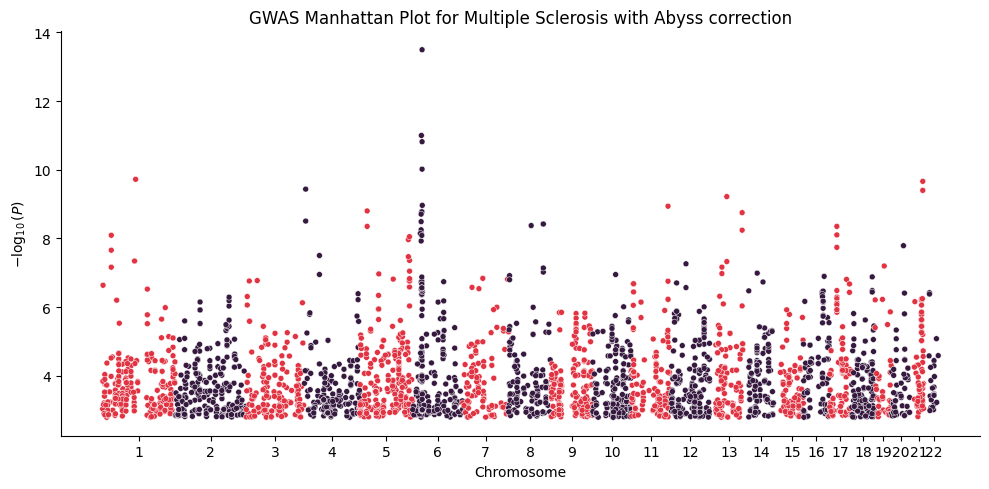

In [7]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find geno and mafs for selected SNPs

In [8]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,cumulative_pos,SNP number,color
26539,1:232925406:C_T_T,-4.657920,-0.021947,5.512662,0.010186,-2.154565,0.031297,1,232925406,3.464247,5,232925406,26539,"(0.20973515, 0.09747934, 0.24238489)"
37799,1:44426948:A_G_A,5.539170,-0.021770,-5.378695,0.009921,-2.194190,0.028319,1,44426948,3.564233,5,44426948,37799,"(0.20973515, 0.09747934, 0.24238489)"
18971,1:167259336:A_T_A,16.480471,0.026007,-17.363882,0.010189,2.552521,0.010757,1,167259336,4.532201,5,167259336,18971,"(0.20973515, 0.09747934, 0.24238489)"
41893,1:108113702:A_G_G,-6.639279,0.021542,7.653381,0.010460,2.059447,0.039561,1,108113702,3.229920,5,108113702,41893,"(0.20973515, 0.09747934, 0.24238489)"
33117,1:87854436:A_G_A,5.563484,0.025589,-5.442605,0.010031,2.550981,0.010804,1,87854436,4.527793,5,87854436,33117,"(0.20973515, 0.09747934, 0.24238489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38719,22:43642153:C_T_T,-6.572149,0.028311,7.602910,0.010334,2.739617,0.006197,22,43642153,5.083648,5,2837211665,38719,"(0.8833417, 0.19830556, 0.26014181)"
45520,22:44705240:A_G_G,-17.800478,-0.021162,19.790469,0.010274,-2.059712,0.039535,22,44705240,3.230561,5,2838274752,45520,"(0.8833417, 0.19830556, 0.26014181)"
32920,22:21404113:A_G_A,-6.307436,-0.019732,7.363447,0.010070,-1.959504,0.050171,22,21404113,2.992316,5,2814973625,32920,"(0.8833417, 0.19830556, 0.26014181)"
9215,22:23723050:A_G_A,9.846214,0.025415,-10.032593,0.010363,2.452461,0.014260,22,23723050,4.250293,5,2817292562,9215,"(0.8833417, 0.19830556, 0.26014181)"


In [9]:
unique_bins = list(sumstat['bin'].unique())

In [10]:
genos = []
mafs = []

# Iterate over unique bins
for unique_bin in unique_bins:
    # Filter sumstat for the current bin
    temp_sumstat = sumstat[sumstat['bin'] == unique_bin]

    # Construct path for genotype mapping
    path_geno_mapping = os.path.join(glob.PATH_GENO, f"01_LD_blocks/{PCs}_PCs/bin_{unique_bin}")
    
    # Load mapping data
    map_file = os.path.join(path_geno_mapping, "mapping.pkl")
    map = pd.read_pickle(map_file)
    map.rename(columns={'Position': 'POS'}, inplace=True)
    map['POS'] = map['POS'].astype(int)

    # Get path for MAF dimensions
    path_dims_of_maf = os.path.join(glob.PATH_GENO, f"02_MAF_probability_landscape/{disease}/bin_{unique_bin}")
    dims_of_maf = os.listdir(path_dims_of_maf)[0]
    path_maf = os.path.join(path_dims_of_maf, dims_of_maf)

    # Merge sumstat with mapping data
    temp_sumstat = pd.merge(temp_sumstat, map[['POS','Chromosome','Alls2', 'path']], on='POS', how='inner')
    
    # Process each unique path
    unique_paths = temp_sumstat['path'].unique()
    for path in unique_paths:
        temp2_sumstat = temp_sumstat[temp_sumstat['path'] == path]
        SNPS = temp2_sumstat['snp'].tolist()
        file_with_snp = next(f for f in os.listdir(path_geno_mapping) if f.startswith(path))
        path_file_genos = os.path.join(path_geno_mapping, file_with_snp)
        path_file_maf = os.path.join(path_maf, file_with_snp)
        geno = pd.read_pickle(path_file_genos)[SNPS]
        temp = geno.T
        temp['snp'] = list(temp.index)
        temp = pd.merge(temp, sumstat[['-logp', 'cumulative_pos','snp']], on='snp', how='inner')
        temp = temp.set_index('snp')
        geno = temp.T
        genos.append(geno)
        
        maf = pd.read_pickle(path_file_maf)[SNPS]
        temp = maf.T
        temp['snp'] = list(temp.index)
        temp = pd.merge(temp, sumstat[['-logp', 'cumulative_pos','snp']], on='snp', how='inner')
        temp = temp.set_index('snp')
        maf = temp.T
        mafs.append(maf)

In [11]:
combined_geno = pd.concat(genos, axis=1)

In [12]:
combined_maf = pd.concat(mafs, axis=1)

In [13]:
combined_maf

snp,1:232925406:C_T_T,1:68237279:A_G_G,1:232908753:C_T_C,2:33464066:A_G_G,9:112271779:A_G_A,10:102631043:A_G_A,10:36171926:A_C_A,10:132139574:C_T_T,11:91320978:C_T_C,11:73611349:C_G_G,...,9:105228941:C_T_T,9:29267427:C_T_T,12:113687859:A_G_A,14:20837033:C_T_T,16:65252673:A_G_G,18:53756180:G_T_T,5:133638156:G_T_T,13:21729226:C_T_C,15:54578561:A_G_A,20:54966146:A_C_A
0,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
1,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
2,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
3,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
4,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69452,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
69453,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
69454,9.326060e-01,9.340720e-01,9.331018e-01,9.394293e-01,9.375570e-01,9.325453e-01,9.327881e-01,9.329442e-01,9.320934e-01,9.362533e-01,...,9.322130e-01,9.264148e-01,9.311188e-01,9.323951e-01,9.295524e-01,9.285610e-01,9.279689e-01,9.208921e-01,9.286058e-01,9.251151e-01
-logp,3.464247e+00,3.103692e+00,3.163807e+00,3.446505e+00,4.151919e+00,2.902708e+00,5.296394e+00,2.988503e+00,3.220053e+00,2.991705e+00,...,3.001132e+00,5.341320e+00,5.432201e+00,6.475471e+00,5.544376e+00,4.266174e+00,3.919243e+00,3.208247e+00,5.790675e+00,2.933367e+00


In [ ]:
path_output = glob.PATH_GENO + "/04_low_P_snps/"
os.makedirs(path_output, exist_ok = True)
combined_geno.to_pickle(path_output+"low_p_geno.pkl")
combined_maf.to_pickle(path_output+"low_p_maf.pkl")


In [15]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in combined_geno.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = combined_geno[cols]

In [16]:
# Split into separate DataFrames based on chromosome
chromosome_maf_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_maf_dfs[chromosome] = combined_maf[cols]

In [27]:
os.listdir(glob.PATH_GENO)

['02_per_chrom',
 '03_macro_similar_AF',
 '06_Concated_latent',
 '07_lowest_dimensionality',
 '08_MAF_probability_landscape',
 '04_LD_blocks',
 '05_Latent_populations',
 '09_summary_statistics',
 '10_lowest_global_dimensionality']

# Order in LD blocks

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from k_means_constrained import KMeansConstrained
from abyss.glob import glob
import random
from math import floor
from collections import Counter

In [18]:
chromosome_dfs

{'1':                 1:109504912:C_T_T  1:30361690:A_G_G  1:201531663:A_G_A  \
 0                   -1.000000e+00      1.000000e+00       1.000000e+00   
 1                    1.000000e+00      1.000000e+00       1.000000e+00   
 2                    1.000000e+00      1.000000e+00       1.000000e+00   
 3                    1.000000e+00      1.000000e+00       1.000000e+00   
 4                    1.000000e+00      1.000000e+00       0.000000e+00   
 ...                           ...               ...                ...   
 69452                1.000000e+00      1.000000e+00       1.000000e+00   
 69453                1.000000e+00      1.000000e+00       1.000000e+00   
 69454                1.000000e+00      1.000000e+00       1.000000e+00   
 pval                 7.344395e+00      7.659067e+00       5.652784e+00   
 cumulative_pos       1.095049e+08      3.036169e+07       2.015317e+08   
 
                 1:30369815:C_T_C  1:214082799:A_G_A  1:30361661:A_C_A  \
 0                 

In [19]:
snp_ids = []
chroms = []
labels = []
PC1s = []
PC2s = []
for chrom_key in chromosome_dfs.keys():
    genos = chromosome_dfs[chrom_key].T
    genos.columns = genos.columns.astype(str)
    nr_snps_in_genos = genos.shape[0]
    
    num_clus = 3
    n_components = 5
    if nr_snps_in_genos < n_components:
        n_components = nr_snps_in_genos
    else:
        pass
    if nr_snps_in_genos > num_clus:
        sample_size = np.round(nr_snps_in_genos//num_clus)
        size_min = sample_size - round(sample_size / 5)
        size_max = (sample_size + round(sample_size / 5))+1
        # Standardize the data
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(genos)
        
        # Perform PCA with n components
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(df_scaled)
        # Create a new DataFrame to store the principal components
        pc_columns = [f'PC{i+1}' for i in range(n_components)]
        df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)
        
        # Apply constrained K-Means clustering
        clf = KMeansConstrained(
            n_clusters=num_clus,
            size_min=size_min,
            size_max=size_max,
            random_state=0
        )
        clf.fit_predict(np.array(df_pca))
        
        # Assign cluster labels to genotypic data
        count = Counter(clf.labels_)
        genos['clusters'] = clf.labels_
    else:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(genos)
        
        # Perform PCA with n components
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(df_scaled)
        pc_columns = [f'PC{i+1}' for i in range(n_components)]
        df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)
        genos['clusters'] = 0
    # Reindex both DataFrames based on row order
    temp = genos.reset_index(drop=True)
    df_pca = df_pca.reset_index(drop=True)
    
    # Concatenate them again
    merged_df = pd.concat([temp, df_pca[pc_columns]], axis=1)
    
    # Set the index of merged_df to match the index of genos
    merged_df.index = genos.index
    genos = merged_df
    for num in genos.clusters.unique():
        to_save = genos.loc[genos['clusters'] == num]
        to_save_snps = to_save.drop(columns=['clusters']+pc_columns).T
        to_save_PCs = to_save[pc_columns].T
        for snp_id in to_save_snps:
            snp_ids.append(snp_id)
            chroms.append(chrom_key)
            labels.append(f"{chrom_key}_{num}")
            PC1s.append(to_save_PCs.loc['PC1'][snp_id])
            try:
                PC2s.append(to_save_PCs.loc['PC2'][snp_id])
            except:
                PC2s.append(0)
            

In [20]:
data = {
    'snp': snp_ids,
    'chroms': chroms,
    'labels': labels,
    'PC1': PC1s,
    'PC2': PC2s
}
df = pd.DataFrame(data)

In [21]:
df

,snp,chroms,labels,PC1,PC2
0,1:109504912:C_T_T,1,1_0,-6.080673,-78.106477
1,1:201531663:A_G_A,1,1_0,-5.913596,-100.567278
2,1:214082799:A_G_A,1,1_0,-2.687319,-72.961009
3,1:57657301:C_T_C,1,1_0,-5.574135,-79.218901
4,1:2329808:A_G_G,1,1_0,-4.421371,-78.221126
...,...,...,...,...,...
295,19:45379791:C_T_C,19,19_0,-51.309597,-11.543496
296,19:34136657:A_G_A,19,19_2,-96.206166,169.481387
297,19:28159914:A_G_A,19,19_2,-83.571464,-156.767542
298,19:3355566:A_G_G,19,19_1,145.307799,5.945739


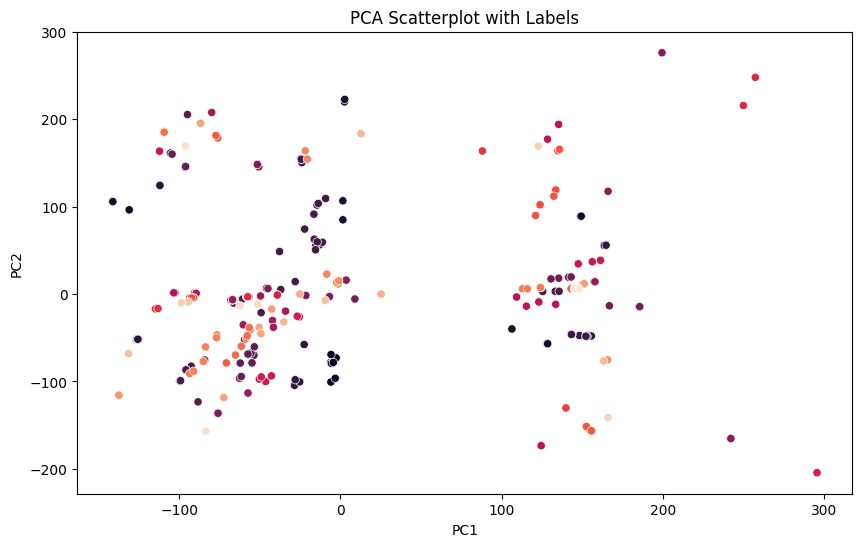

In [22]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='PC1', y='PC2', hue='labels', palette='rocket', data=df, legend= False)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

In [23]:
temp_sumstat = pd.merge(temp_sumstat, df, on='snp', how='inner')

In [24]:
temp_sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,...,cumulative_pos,SNP number,color,Chromosome,Alls2,path,chroms,labels,PC1,PC2
0,1:109504912:C_T_T,4.796280,-0.034119,-4.598361,0.009988,-3.416004,0.000646,1,109504912,7.344395,...,109504912,2691,"(0.20973515, 0.09747934, 0.24238489)",1,C_T_T,18_2,1,1_0,-6.080673,-7.810648e+01
1,1:30361690:A_G_G,9.591147,-0.036129,-9.842370,0.010319,-3.501200,0.000472,1,30361690,7.659067,...,30361690,30674,"(0.20973515, 0.09747934, 0.24238489)",1,A_G_G,40_1,1,1_1,148.894691,8.867566e+01
2,1:201531663:A_G_A,6.001507,0.029251,-5.960399,0.010010,2.922281,0.003508,1,201531663,5.652784,...,201531663,4188,"(0.20973515, 0.09747934, 0.24238489)",1,A_G_A,34_1,1,1_0,-5.913596,-1.005673e+02
3,1:30369815:C_T_C,4.013108,-0.034809,-3.792792,0.010340,-3.366537,0.000773,1,30369815,7.164770,...,30369815,25517,"(0.20973515, 0.09747934, 0.24238489)",1,C_T_C,45_1,1,1_1,149.332504,8.880749e+01
4,1:214082799:A_G_A,-3.786955,0.030737,4.578199,0.010159,3.025472,0.002509,1,214082799,5.987797,...,214082799,34410,"(0.20973515, 0.09747934, 0.24238489)",1,A_G_A,8_2,1,1_0,-2.687319,-7.296101e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,21:40612466:C_T_C,-0.768217,0.028718,1.360245,0.010054,2.856520,0.004321,21,40612466,5.444376,...,2536618368,43468,"(0.20973515, 0.09747934, 0.24238489)",21,C_T_C,8_1,21,21_2,-66.940047,-6.406013e+00
296,21:44784639:C_T_C,-1.431127,0.043364,2.096315,0.010824,4.006220,0.000064,21,44784639,9.662835,...,2540790541,29846,"(0.20973515, 0.09747934, 0.24238489)",21,C_T_C,40_1,21,21_1,242.157993,-1.648957e+02
297,21:43456164:C_T_C,3.757376,0.031391,-3.520309,0.010114,3.103635,0.001934,21,43456164,6.248060,...,2539462066,6362,"(0.20973515, 0.09747934, 0.24238489)",21,C_T_C,35_0,21,21_1,199.607452,2.760733e+02
298,22:19955157:A_G_G,-5.975036,0.032331,6.925455,0.010248,3.154953,0.001625,22,19955157,6.421996,...,2560745809,21166,"(0.8833417, 0.19830556, 0.26014181)",22,A_G_G,17_2,22,22_0,25.238859,8.406229e-15


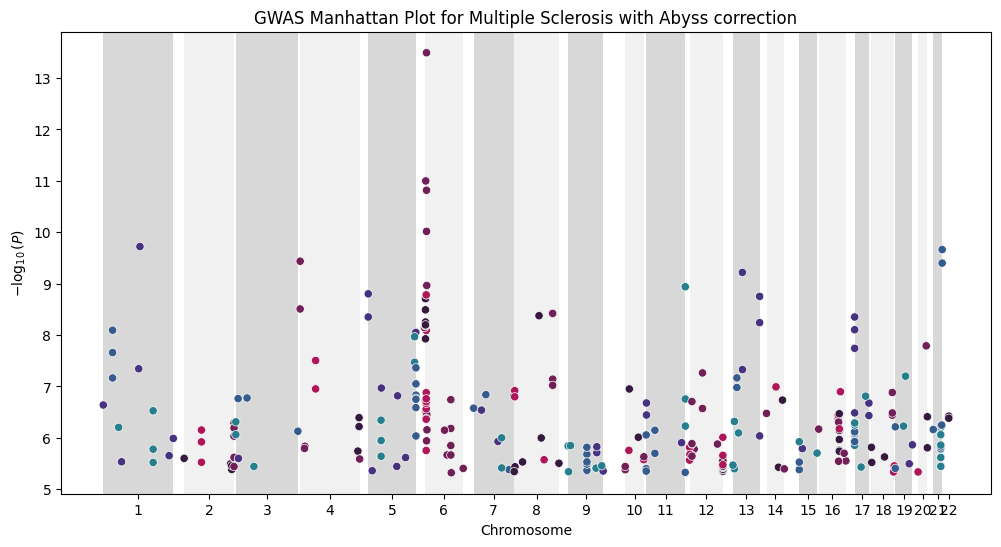

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define two palettes

even_palette = sns.color_palette("rocket")  # Lighter palette for even chromosomes
odd_palette = sns.color_palette("viridis")     # Darker palette for odd chromosomes

# Define background colors for segments
bg_color_even = "lightgrey"  # Background color for even segments
bg_color_odd = "grey"        # Background color for odd segments

# Create a figure for the Manhattan plot
plt.figure(figsize=(12, 6))

# Get start, end positions and midpoints for each chromosome
chromosomes = temp_sumstat['#CHROM'].unique()
chrom_midpoints = []
start_end_positions = []
for chrom in chromosomes:
    start = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].min()
    end = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].max()
    midpoints = (start + end) / 2
    chrom_midpoints.append(midpoints)
    start_end_positions.append((start, end))

# Add a background color for each chromosome segment
for i, (start, end) in enumerate(start_end_positions):
    chrom = chromosomes[i]
    plt.axvspan(start, end, facecolor=bg_color_even if chrom % 2 == 0 else bg_color_odd, alpha=0.3)

# Plot the data
sns.scatterplot(
    data=temp_sumstat,
    x='cumulative_pos',
    y='-logp',
    hue='labels',
    palette={label: (even_palette if int(label.split('_')[0]) % 2 == 0 else odd_palette)[int(label.split('_')[1]) % len(even_palette)] for label in temp_sumstat['labels'].unique()},
    legend=False
)

# Set title and axis labels
plt.title(f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
plt.xlabel("Chromosome")
plt.ylabel(r"$-\log_{10}(P)$")

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(chromosomes)  # Reversing the order of chromosomes
plt.xticks(chrom_midpoints, chrom_labels)

# Set the tick labels at a 45-degree angle
plt.xticks(rotation=0)

# Show the plot
plt.show()
